In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
import similaritymeasures

warnings.filterwarnings("ignore")

In [2]:
# loads dataframe of training (w/ classLabels), splits classes, returns two dfs
def load_split_class(run_fold, data_path):
    training_data = pd.read_csv(data_path + "/orig/orig_run_" + str(run_fold) + "_train.csv")

    # split classLabel column
    X_train_fold = training_data.iloc[:, :-1]
    y_train_fold = training_data.iloc[:, -1]

    # split pos and neg
    X_train_pos = X_train_fold.loc[y_train_fold == 1]
    X_train_neg = X_train_fold.loc[y_train_fold == 0]

    print("Positive samples: %d" % X_train_pos.shape[0])
    print("Negative samples: %d" % X_train_neg.shape[0])

    return training_data, X_train_pos, X_train_neg

In [3]:
# returns weighted blend of 2 parent spectra at each intensity point
def double_blend(spectra, weights):
    # for every two parent spectra calculate 5 weighted values at each intensity point

    blended_spectra = pd.DataFrame(columns=spectra.columns)
    num_samples = spectra.shape[0]

    print("\nStarting blending...")
    start_time = time.time()
    for i in range(num_samples):  # parent A
        for j in range(i + 1, num_samples):  # parent B

            # 0.1A + 0.9B, 0.2A + 0.8B, 0.3A + 0.7B etc..
            for a, b in zip(weights, reversed(weights)):
                weighted_spectra = (a * spectra.iloc[i]) + (b * spectra.iloc[j])  # returns pd series
                blended_spectra = blended_spectra.append(weighted_spectra, ignore_index=True)

    print("Blending took approx: %s minutes" % round((time.time() - start_time) / 60, 4))
    print()

    # returns (θn * (n-1)) / 2 spectra
    return blended_spectra

In [4]:
# === PARAMs === #
# (9n * (n-1)) / 2 spectra
double_blended_weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
path = '../data/chlorinated'
data_shape = 2473

for run in range(1, 4):
    print("Loading run " + str(run) + " data")
    
    name = "blended_run_" + str(run) + "_train.csv"
    
    # split data into positive and negative
    all_data, X_train_pos, X_train_neg = load_split_class(run, path)
        
    # blend data and reassign labels
    pos_blend_spectra = double_blend(X_train_pos, double_blended_weights)
    pos_blend_spectra["classLabel"] = 1

    neg_blend_spectra = double_blend(X_train_neg, double_blended_weights)
    neg_blend_spectra["classLabel"] = 0
    
    # to store all possible synthetic data comment this line
    # to store randomly sampled data with class prior probability run this
    #sample_pos = (neg_blend_spectra.shape[0] // 33) * 67
    
    # sample for augmentation
    #positive_samples = pos_blend_spectra.sample(n=sample_pos, replace=False)
    print(pos_blend_spectra.shape)
    print(neg_blend_spectra.shape)

    # concat blended data
    concat_spectra = pd.concat([pos_blend_spectra, neg_blend_spectra])
    print(concat_spectra.shape)
    
    # save file to csv
    concat_spectra.to_csv(path + "/blended/" + name, index=False)
    
    # clear up memory for dfid
    del all_data
    del X_train_pos
    del X_train_neg
    #del positive_samples
    del pos_blend_spectra
    del neg_blend_spectra
    del concat_spectra
    gc.collect()

Loading run 1 data
Positive samples: 51
Negative samples: 25

Starting blending...
Blending took approx: 4.6213 minutes


Starting blending...
Blending took approx: 0.283 minutes

(11475, 2474)
(2700, 2474)
(14175, 2474)
Loading run 2 data
Positive samples: 51
Negative samples: 25

Starting blending...
Blending took approx: 4.5862 minutes


Starting blending...
Blending took approx: 0.2781 minutes

(11475, 2474)
(2700, 2474)
(14175, 2474)
Loading run 3 data
Positive samples: 51
Negative samples: 25

Starting blending...
Blending took approx: 4.5824 minutes


Starting blending...
Blending took approx: 0.2794 minutes

(11475, 2474)
(2700, 2474)
(14175, 2474)


In [5]:
dfids = []
spectral_subtractions = []

# calculate coupling distance and spectral subtraction
for i in range(1, 4):
    real_data = pd.read_csv(path + "/orig/orig_run_" + str(i) + "_train.csv")
    synth_data = pd.read_csv(path + "/blended/blended_run_" + str(i) + "_train.csv")
    
    # Get mean spectra of both - need to reshape for frdist
    mean_real = real_data.iloc[:, :-1].mean().to_numpy().reshape(data_shape, 1)
    mean_synth = synth_data.iloc[:, :-1].mean().to_numpy().reshape(data_shape, 1)
    
    dfids.append(similaritymeasures.frechet_dist(mean_real, mean_synth))    
    spectral_subtractions.append((mean_real - mean_synth).reshape(1, data_shape))

distances = pd.DataFrame({'DFIDs': dfids})
distances.head()

,DFIDs
0,0.033939
1,0.034419
2,0.030106


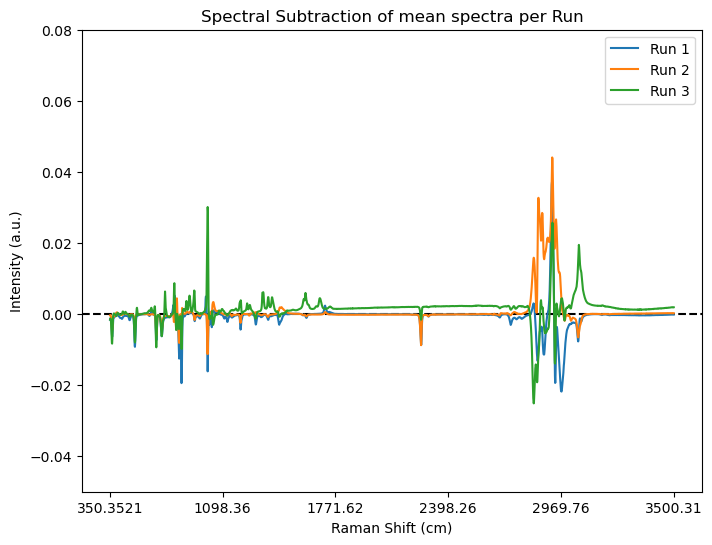

In [6]:
xVal = np.array([real_data.columns[j] for j in range(data_shape)])
subtractions = pd.DataFrame([], columns=xVal)

for i in range(len(spectral_subtractions)):
    temp = spectral_subtractions[i].reshape(data_shape)
    subtractions.loc[i] = pd.Series(temp, name=i, index=xVal)


xticks = np.floor(np.linspace(0, data_shape-1, 6)).astype("int")

# plot
plt.figure(figsize=(8, 6))
plt.xlabel("Raman Shift (cm)")
plt.ylabel("Intensity (a.u.)")
plt.title("Spectral Subtraction of mean spectra per Run")
plt.xticks(xticks)
plt.ylim([-0.05, 0.08])
plt.axhline(y=0, color='k', linestyle='--')

plt.plot(subtractions.iloc[0, :],  label="Run 1")
plt.plot(subtractions.iloc[1, :],  label="Run 2")
plt.plot(subtractions.iloc[2, :],  label="Run 3")

plt.legend()